In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
#using the csv files to load data_1,data_2,data_3 
data_1=pd.read_csv("data_1.csv")
data_2=pd.read_csv("data_2.csv")
data_3=pd.read_csv("data_3.csv")

#using date as index
data_1=data_1.set_index("Date")
data_2=data_2.set_index("Date")
data_3=data_3.set_index("Date")


In [87]:
#MSFT

#this can be changed accordingly
X=data_2
test_size=0.2

# X.index = pd.to_datetime(X.index)



# analysis using first data
train_size=int((1-test_size)*len(X))
X_train,X_test=X.iloc[:train_size],X.iloc[train_size:]


X_test=X_test.iloc[:50]

print(X_train.shape,X_test.shape)

(634, 1) (50, 1)


In [88]:
print("Description and Summary Statistics of data: ")
X_train.describe()

Description and Summary Statistics of data: 


,MSFT
count,634.000000
mean,324.733495
std,70.992469
min,209.393280
25%,257.469543
50%,321.358017
75%,400.310280
max,464.002502


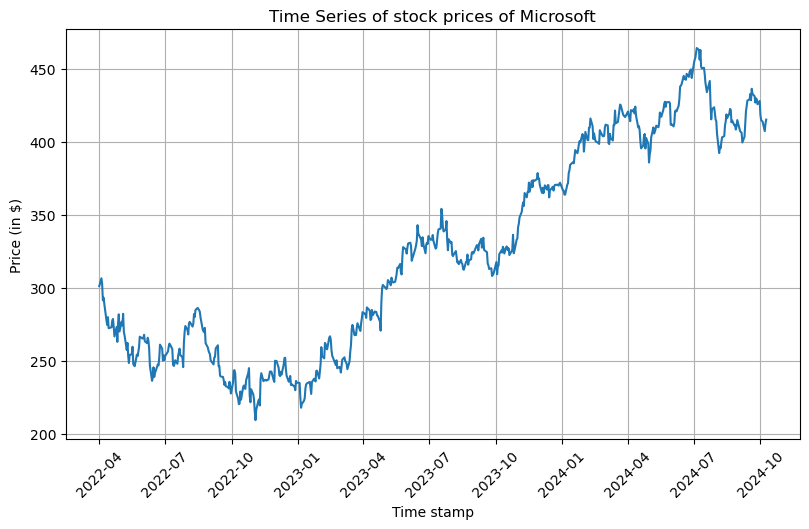

In [89]:
plt.figure(figsize=(8,5))
plt.plot(X_train)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.tight_layout()

plt.xlabel("Time stamp")
plt.ylabel("Price (in $)")
plt.grid(True)
plt.title("Time Series of stock prices of Microsoft");
plt.savefig("microsoft_series.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg




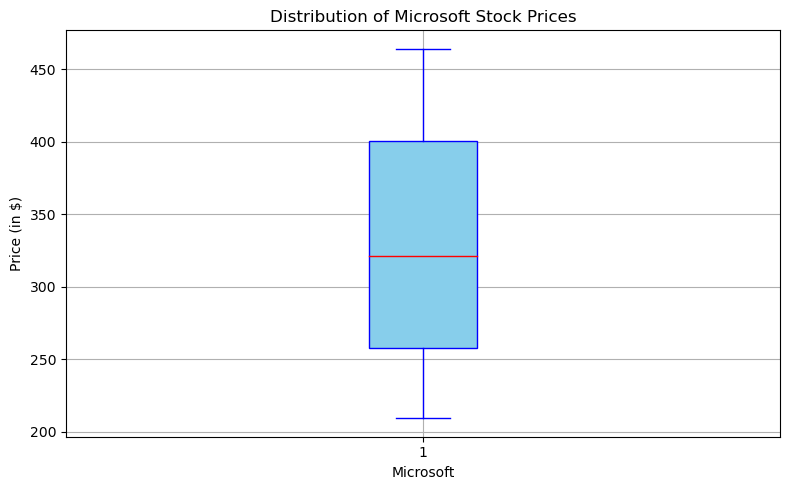

In [90]:
#Boxplot of the data
plt.figure(figsize=(8, 5))
plt.boxplot(X_train, 
            vert=True, 
            patch_artist=True,  # Required to fill the boxes with color
            boxprops=dict(facecolor='skyblue', color='blue'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            flierprops=dict(markerfacecolor='orange', marker='o', markersize=5, linestyle='none', markeredgecolor='gray'))

plt.xlabel("Microsoft")
plt.ylabel("Price (in $)")
plt.title("Distribution of Microsoft Stock Prices")
plt.grid(True)

plt.tight_layout()
plt.savefig("microsoft_boxplot.png", dpi=300, bbox_inches='tight')
plt.show()


In [91]:
#testting for the stationarity of the chosen series
#using Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity_adf(timeseries,autolag="AIC",maxlag=None):

    '''
    lag: can be "AIC" or "BIC"
    '''

    
    dftest=adfuller(timeseries,autolag=autolag,maxlag=maxlag)
    # Format results
    df_output = pd.Series(dftest[0:4], index=[
        "Test Statistic", 
        "p-value",
        "#Lags Used", 
        "Number of Observations Used"
    ])
    if maxlag is None:
        df_output.loc[f"{autolag}"]=dftest[5]
    return df_output
print("Results of ADF Test on the level:")
test_stationarity_adf(X_train,maxlag=None,autolag="AIC")



Results of ADF Test on the level:


Test Statistic                   -0.352528
p-value                           0.917728
#Lags Used                        2.000000
Number of Observations Used     631.000000
AIC                            3727.501572
dtype: float64

In [92]:
# above result shows that series is not stationary . We now check for the first differece.
print("Results of ADF test on the first difference: ")
test_stationarity_adf(X_train.diff().dropna(),maxlag=None,autolag="AIC")


Results of ADF test on the first difference: 


Test Statistic                  -19.694248
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used     631.000000
AIC                            3720.013908
dtype: float64

In [93]:
from arch.unitroot import PhillipsPerron

def test_stationarity_pp(timeseries, lags=None, trend='c'):
    '''
    timeseries: the time series to test
    lags: number of lags to use; if None, automatically selected
    trend: 'c' (constant), 'ct' (constant + trend), or 'n' (none)
    '''

    print("Results of Phillips-Perron Test:")
    pp_test = PhillipsPerron(timeseries, lags=lags, trend=trend)
    
    # Collecting the test output
    result = {
        "Test Statistic": pp_test.stat,
        "p-value": pp_test.pvalue,
        "#Lags Used": pp_test.lags,
        "Trend": trend,
        "Critical Values": pp_test.critical_values
    }

    return pd.Series(result)

# Example usage
test_stationarity_pp(X_train, lags=None, trend='c')


Results of Phillips-Perron Test:


Test Statistic                                             -0.377797
p-value                                                      0.91374
#Lags Used                                                        20
Trend                                                              c
Critical Values    {'1%': -3.4407228537258865, '5%': -2.866116759...
dtype: object

In [94]:
test_stationarity_pp(X_train.diff().dropna(), lags=None, trend='c')

Results of Phillips-Perron Test:


Test Statistic                                            -25.546046
p-value                                                          0.0
#Lags Used                                                        20
Trend                                                              c
Critical Values    {'1%': -3.4407393338535655, '5%': -2.866124018...
dtype: object

<Figure size 800x800 with 0 Axes>

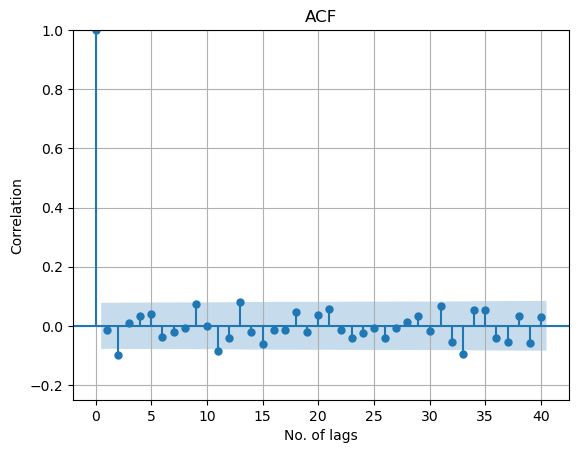

In [95]:
diff_series = X_train.diff().dropna()


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(8, 8))
plot_acf(diff_series, lags=40)
plt.title("ACF")
plt.grid()
plt.ylim(-0.25,1)
plt.xlabel("No. of lags")
plt.ylabel("Correlation")
plt.savefig("microsoft_acf.png", dpi=300, bbox_inches='tight')
plt.show()




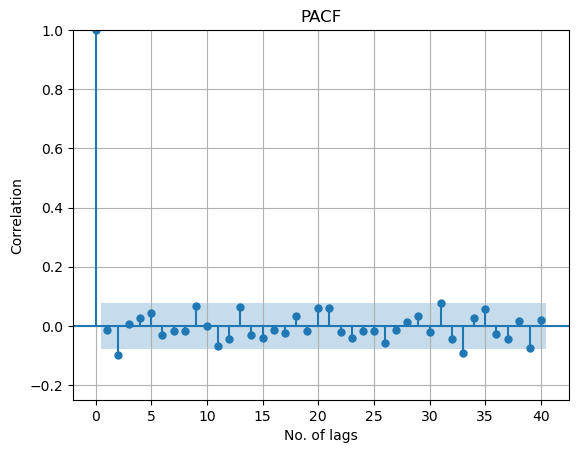

In [96]:
plot_pacf(diff_series, lags=40)
plt.title("PACF")
plt.grid()
plt.ylim(-0.25,1)
plt.xlabel("No. of lags")
plt.ylabel("Correlation")
plt.savefig("microsoft_pacf.png", dpi=300, bbox_inches='tight')
plt.show()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3871.683, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3873.553, Time=0.05 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3869.585, Time=0.11 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3871.406, Time=0.16 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=3872.872, Time=0.18 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=3874.067, Time=0.26 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3873.579, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3874.076, Time=0.15 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3871.470, Time=0.19 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3872.965, Time=0.34 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=3874.664, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3869.225, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3871.213, Time=0.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=3868.123, Time=0.51 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=3869.778, Time=0.61 sec
 ARIMA(3,1

C:\Users\91933\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\91933\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


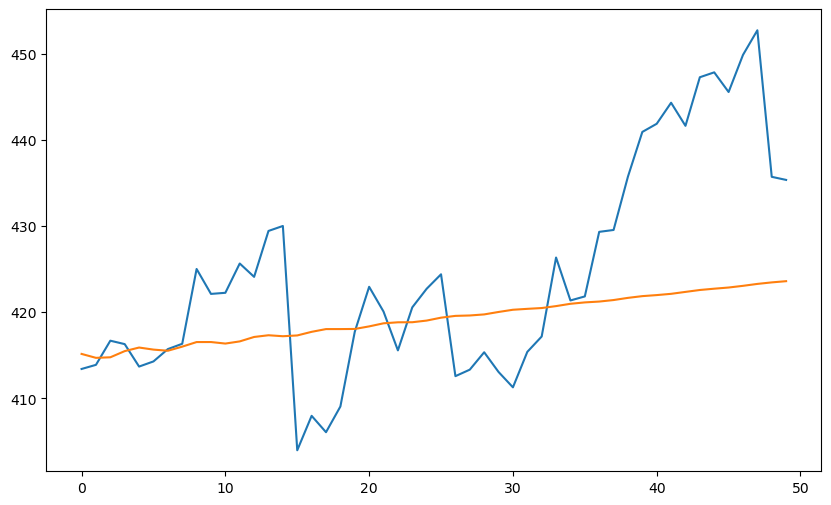

In [10]:
from pmdarima.model_selection import RollingForecastCV
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

cv = RollingForecastCV(h=10, initial=0.8)  # 80% initial train, rolling forecast

model_arima = auto_arima(X_train,
                   d=1,
                   start_p=0, max_p=40,
                   start_q=0, max_q=40,
                   seasonal=False,
                   cv=cv,
                   stepwise=False,  # exhaustive search
                   error_action='ignore',
                   suppress_warnings=True,
                   trace=True,
                   scoring='mse')

print(model_arima.summary())



model_arima.fit(X_train)
n_periods = len(X_test)
forecast = model_arima.predict(n_periods=n_periods)



plt.figure(figsize=(10,6))
X_test=X_test.reset_index(drop=True)
forecast.reset_index(drop=True,inplace=True)

plt.plot(X_test)


plt.plot(forecast)
plt.show()



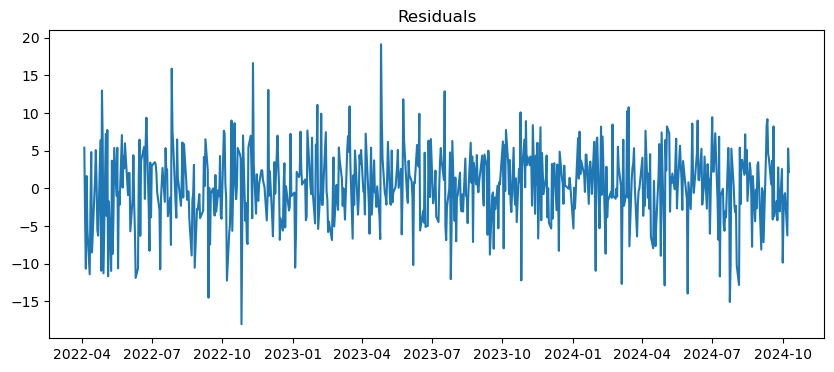

In [68]:
from statsmodels.tsa.arima.model import ARIMA

import warnings

warnings.filterwarnings("ignore")

model=ARIMA(X_train,order=(2,1,2))
model_fit=model.fit()

residuals=model_fit.resid
residuals=residuals.iloc[1:]



import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Residual plot
plt.figure(figsize=(10, 4))
plt.plot(residuals)
plt.title("Residuals")
plt.savefig("arima_resid.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg

plt.show()






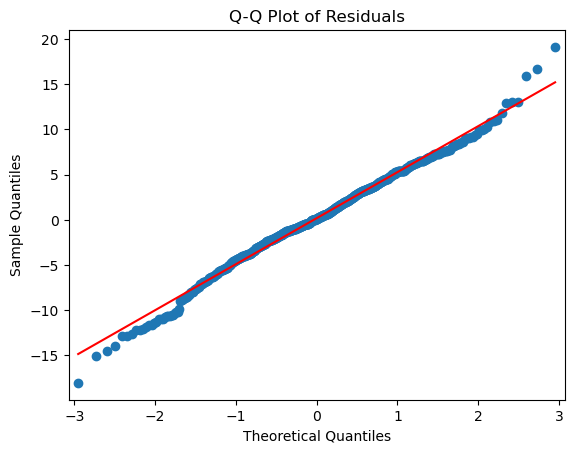

In [69]:
# Q-Q plot
sm.qqplot(residuals, line='s')
plt.title("Q-Q Plot of Residuals")
plt.savefig("qq_arima.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg

plt.show()

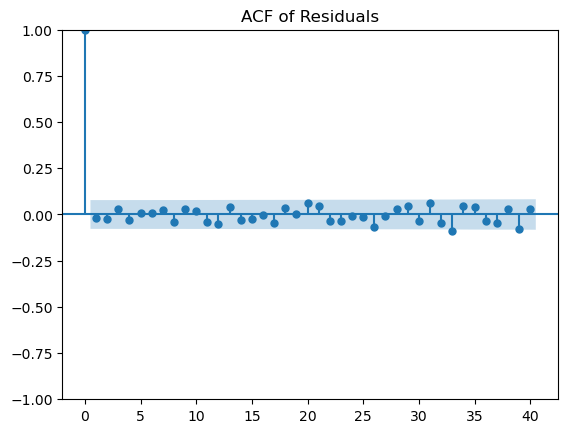

In [70]:
# ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.title("ACF of Residuals")
plt.savefig("acf_resid_arima.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg

plt.show()


In [12]:
from statsmodels.stats.diagnostic import acorr_ljungbox

# residuals is typically model_fit.resid
lb_test = acorr_ljungbox(residuals, lags=[10,20,30,35], return_df=True)
print(lb_test)

      lb_stat  lb_pvalue
10   3.938075   0.950097
20  13.307167   0.863819
30  22.116045   0.849789
35  33.976024   0.517396


In [13]:
from scipy.stats import shapiro


stat, p = shapiro(residuals)
print("Shapiro-Wilk Test Statistic =", stat)
print("p-value =", p,"\n")

if p > 0.05:
    print("Residuals are likely normally distributed (fail to reject H_0)")
else:
    print("Residuals are not normally distributed (reject H_0)")


Shapiro-Wilk Test Statistic = 0.9928312301635742
p-value = 0.0039564697071909904 

Residuals are not normally distributed (reject H_0)


 RMSE: 6.9674


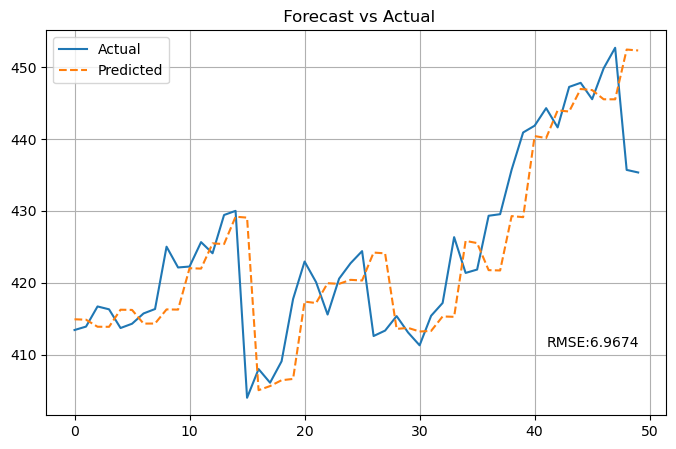

In [107]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Flatten and convert to float
X_train_flat = X_train.values.ravel() if hasattr(X_train, 'values') else np.ravel(X_train)
X_test_flat = X_test.values.ravel() if hasattr(X_test, 'values') else np.ravel(X_test)

train = list(X_train_flat.astype(float))
test = list(X_test_flat.astype(float))

predictions_arima = []
order = (1, 1, 1)  # Replace with optimal order
step_size = 2

for t in range(0, len(test), step_size):
    model = ARIMA(np.array(train), order=order)
    model_fit = model.fit()
    
    # Forecast up to 5 steps ahead (or fewer at the end)
    steps = min(step_size, len(test) - t)
    forecast = model_fit.forecast(steps=steps)
    predictions_arima.extend(forecast)
    
    # Update train with the actual next 5 values
    actuals = test[t:t + steps]
    train.extend(actuals)

 
    
# Evaluation and plot
rmse = np.sqrt(mean_squared_error(test[:len(predictions_arima)], predictions_arima))
print(f" RMSE: {rmse:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(test, label='Actual')
plt.plot(predictions_arima, label='Predicted', linestyle='--')
plt.legend()
plt.title(f" Forecast vs Actual")
plt.grid(True)
plt.text(x=41,y=411,s=f"RMSE:{rmse:.4f}")
plt.savefig("forecast_arima.png", dpi=300, bbox_inches='tight')# Options: png, jpg, pdf, svg

plt.show()


In [72]:
from arch import arch_model
from statsmodels.stats.diagnostic import het_arch

lags=range(10,45,5)

# ARCH LM test from statsmodels
for lag in lags:
    lm_test = het_arch(residuals, nlags=lag) 
    print(f"Results of Arch LM test for ARIMA residuals for lags= {lag}")
    print("LM Stat:", lm_test[0])
    print("p-value:", lm_test[1])
    print("\n")


Results of Arch LM test for ARIMA residuals for lags= 10
LM Stat: 4.379224603709352
p-value: 0.9286223566645775


Results of Arch LM test for ARIMA residuals for lags= 15
LM Stat: 16.030258221908053
p-value: 0.38004353005280095


Results of Arch LM test for ARIMA residuals for lags= 20
LM Stat: 15.16343208210624
p-value: 0.7669808295056048


Results of Arch LM test for ARIMA residuals for lags= 25
LM Stat: 22.427624075617924
p-value: 0.6109478378609567


Results of Arch LM test for ARIMA residuals for lags= 30
LM Stat: 26.262654889896858
p-value: 0.6616599634473637


Results of Arch LM test for ARIMA residuals for lags= 35
LM Stat: 36.675376824753286
p-value: 0.39103812004986693


Results of Arch LM test for ARIMA residuals for lags= 40
LM Stat: 41.06518450080616
p-value: 0.42367125352663987




**Since ARCH-LM test indicates that there are no ARCH effect, that is, residuals are homoskedastistic**
**Hence, There is no need to include GARCH**

In [17]:
squared_residuals_arima=residuals**2

In [18]:
squared_residuals_arima.describe()

count    633.000000
mean      25.930301
std       41.431838
min        0.000002
25%        1.905842
50%       10.578376
75%       31.747511
max      365.723193
dtype: float64

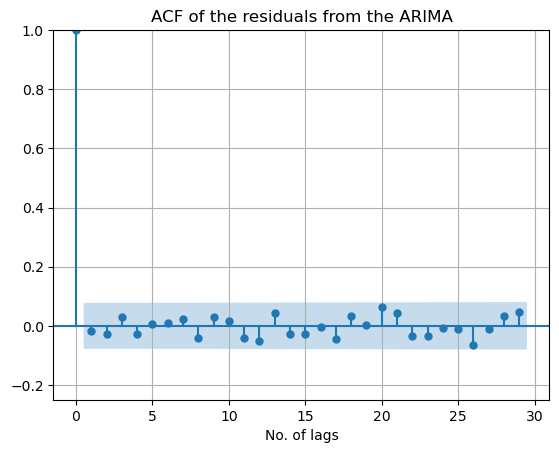

In [75]:
plot_acf(residuals)
plt.grid(True)
plt.title("ACF of the residuals from the ARIMA")
plt.xlabel("No. of lags")
plt.ylim(-0.25,1);
plt.savefig("residual_acf.png", dpi=300, bbox_inches='tight')

In [20]:
# optimal lag should be something like 26

In [21]:
pip install numpy==1.23.5


Note: you may need to restart the kernel to use updated packages.


In [99]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Convert residuals to supervised learning format
def create_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df_supervised = pd.concat(columns, axis=1)
    df_supervised.fillna(0, inplace=True)
    return df_supervised.values

# Example: use lag=1 (can be tuned)
lag = 26
supervised = create_supervised(residuals, lag)
X, y = supervised[:, :-1], supervised[:, -1]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1))

# Reshape for LSTM [samples, features,timestamp]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1,lag))



In [100]:
X_scaled.mean(axis=0)


array([[0.49024245, 0.49001736, 0.49028267, 0.4903093 , 0.4903503 ,
        0.49050886, 0.49092776, 0.49081835, 0.49094844, 0.49099778,
        0.49087979, 0.4910598 , 0.49113106, 0.49128937, 0.4909398 ,
        0.49111524, 0.49095993, 0.49093724, 0.49077017, 0.49057521,
        0.49018462, 0.48982821, 0.48966689, 0.48997039, 0.48998928,
        0.48998803]])

In [101]:
X_scaled.var()


0.01842676153183694

In [102]:
X_scaled.shape

(633, 1, 26)

In [26]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import itertools

# Your existing setup
lag = 26
supervised = create_supervised(residuals, lag)
X, y = supervised[:, :-1], supervised[:, -1]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Reshape for LSTM
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, lag))

# Hyperparameter grid
param_grid = {
    'units': [25, 50, 75,100],
    'dropout_rate': [0.0, 0.2,0.4],
    'batch_size': [8, 16],
    'optimizer': ['adam']
}

param_combinations = list(itertools.product(*param_grid.values()))

# One-step ahead cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Model builder
def build_model(units, dropout_rate, optimizer):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(1, lag)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Grid Search Loop
best_rmse = float('inf')
best_params = None

for params in param_combinations:
    units, dropout_rate, batch_size, optimizer = params
    rmses = []

    for train_idx, val_idx in tscv.split(X_scaled):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

        model = build_model(units, dropout_rate, optimizer)
        model.fit(X_train, y_train, epochs=25, batch_size=batch_size, verbose=0)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    avg_rmse = np.mean(rmses)
    print(f"Params: {params} → Avg RMSE: {avg_rmse:.5f}")

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = params

print(f"\n✅ Best Parameters: {best_params} → RMSE: {best_rmse:.5f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000014E0DF0D4C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Params: (25, 0.0, 8, 'adam') → Avg RMSE: 0.13

In [139]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(25, activation='relu',dropout=0.4, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm.fit(X_scaled, y_scaled, epochs=100, batch_size=8, verbose=1)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2300
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0333
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0317
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0248
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0253
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0250
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0182
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0202
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0190
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0178
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0173
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0198
Epoc

In [140]:
model_lstm.summary()

Model: "sequential_124"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_124 (LSTM)                      │ (None, 25)                  │           5,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_124 (Dense)                    │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,680 (61.25 KB)

 Trainable params: 5,226 (20.41 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,454 (40.84 KB)

In [141]:
X_test=np.array(X_test)

In [142]:

# Start with the last `lag` residuals
last_input = residuals[-lag:]  # shape: (16,)
lstm_predictions = []
last_input=np.array(last_input)
# Normalize using the same scaler used for X
last_input_scaled = scaler.transform(last_input.reshape(-1, 1)).flatten()

n_pred=15

for _ in range(n_pred):
    # Reshape to match LSTM input shape: (1 sample, 1 timestep, lag features)
    input_reshaped = last_input_scaled.reshape(1, 1, lag)

    # Predict the next residual
    next_pred_scaled = model_lstm.predict(input_reshaped, verbose=0)

    # Inverse transform to original scale
    next_pred = scaler.inverse_transform(next_pred_scaled)[0, 0]

    # Save prediction
    lstm_predictions.append(next_pred)

    # Update input: remove oldest, append newest predicted value (scaled)
    last_input_scaled = np.append(last_input_scaled[1:], next_pred_scaled)

# Final predictions (in original scale)
print(f"Next {n_pred} predicted residuals:\n", lstm_predictions)


Next 15 predicted residuals:
 [0.48852998, 0.51132643, 0.64445966, 0.3723728, 0.4827229, 0.5082524, 0.64720374, 0.4868224, 0.5298263, 0.72597146, 0.447072, 0.39929757, 0.634954, 0.6086449, 0.37622428]


RMSE is 3.2015509701987885


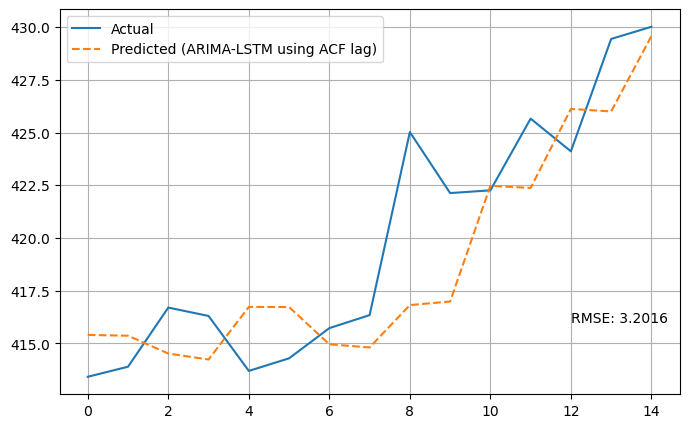

In [144]:
arima_lstm_predictions=np.array(predictions_arima[:n_pred])+np.array(lstm_predictions)

rmse = np.sqrt(mean_squared_error(X_test[:n_pred],arima_lstm_predictions))
print(f"RMSE is {rmse}")

plt.figure(figsize=(8, 5))
plt.plot(X_test[:n_pred],label="Actual")
plt.plot(arima_lstm_predictions,label='Predicted (ARIMA-LSTM using ACF lag)', linestyle='--')
plt.grid(True)


plt.legend()
plt.text(s=f"RMSE: {rmse:.4f}",x=12,y=416)
plt.savefig("result_arima_lstm_acf.png", dpi=300, bbox_inches='tight')
plt.show()





In [77]:
def create_lagged_features(series, max_lag=16):
    df = pd.DataFrame({'y': series})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df['y'].shift(lag)
    df = df.dropna()
    return df


df_lags = create_lagged_features(residuals, max_lag=16)


In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [79]:
# Prepare data
X_rf = df_lags.drop('y', axis=1)
y_rf = df_lags['y']

# Fit Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_rf, y_rf)

# Get feature importances and select top lags
importances = rf.feature_importances_
lag_features = X_rf.columns[np.argsort(importances)[::-1]]
top_lags = lag_features[:5]  # Select top 5 lags (adjust as needed)
print("Selected lags:", top_lags)


Selected lags: Index(['lag_11', 'lag_13', 'lag_8', 'lag_1', 'lag_6'], dtype='object')


In [82]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import itertools

# Your existing setup
lag = 13
supervised = create_supervised(residuals, lag)
X, y = supervised[:, :-1], supervised[:, -1]

# Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.reshape(-1, 1)).ravel()

# Reshape for LSTM
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, lag))

# Hyperparameter grid
param_grid = {
    'units': [25, 50, 75,100],
    'dropout_rate': [0.0, 0.2,0.4],
    'batch_size': [8, 16],
    'optimizer': ['adam']
}

param_combinations = list(itertools.product(*param_grid.values()))

# One-step ahead cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Model builder
def build_model(units, dropout_rate, optimizer):
    model = Sequential()
    model.add(LSTM(units, activation='relu', input_shape=(1, lag)))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Grid Search Loop
best_rmse = float('inf')
best_params = None

for params in param_combinations:
    units, dropout_rate, batch_size, optimizer = params
    rmses = []

    for train_idx, val_idx in tscv.split(X_scaled):
        X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_train, y_val = y_scaled[train_idx], y_scaled[val_idx]

        model = build_model(units, dropout_rate, optimizer)
        model.fit(X_train, y_train, epochs=25, batch_size=batch_size, verbose=0)

        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        rmses.append(rmse)

    avg_rmse = np.mean(rmses)
    print(f"Params: {params} → Avg RMSE: {avg_rmse:.5f}")

    if avg_rmse < best_rmse:
        best_rmse = avg_rmse
        best_params = params

print(f"\n✅ Best Parameters: {best_params} → RMSE: {best_rmse:.5f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002AC4C20D0D0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Params: (25, 0.0, 8, 'adam') → Avg RMSE: 0.13

In [145]:
# Define LSTM model
model_lstm = Sequential()
model_lstm.add(LSTM(100, activation='relu',dropout=0.4, input_shape=(X_scaled.shape[1], X_scaled.shape[2])))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')

# Fit model
model_lstm.fit(X_scaled, y_scaled, epochs=100, batch_size=8, verbose=1)


Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0850
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0280
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0220
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0227
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0225
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0201
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0222
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0203
Epoch 10/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188
Epoch 11/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188
Epoch 12/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0206
Epoch 13/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199
Epoch 14/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoch 15/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0192
Epoc

In [146]:
model_lstm.summary()

Model: "sequential_125"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_125 (LSTM)                      │ (None, 100)                 │          50,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_125 (Dense)                    │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 152,705 (596.51 KB)

 Trainable params: 50,901 (198.83 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,804 (397.68 KB)

In [147]:
# Start with the last `lag` residuals
last_input = residuals[-lag:]  # shape: (16,)
lstm_predictions = []
last_input=np.array(last_input)
# Normalize using the same scaler used for X
last_input_scaled = scaler.transform(last_input.reshape(-1, 1)).flatten()

n_pred=15

for _ in range(n_pred):
    # Reshape to match LSTM input shape: (1 sample, 1 timestep, lag features)
    input_reshaped = last_input_scaled.reshape(1, 1, lag)

    # Predict the next residual
    next_pred_scaled = model_lstm.predict(input_reshaped, verbose=0)

    # Inverse transform to original scale
    next_pred = scaler.inverse_transform(next_pred_scaled)[0, 0]

    # Save prediction
    lstm_predictions.append(next_pred)

    # Update input: remove oldest, append newest predicted value (scaled)
    last_input_scaled = np.append(last_input_scaled[1:], next_pred_scaled)

# Final predictions (in original scale)
print(f"Next {n_pred} predicted residuals:\n", lstm_predictions)


Next 15 predicted residuals:
 [-0.23158926, -0.24447802, -0.15767077, -0.047553238, -0.093730845, -0.06871742, -0.037348762, -0.04333967, -0.29681262, -0.0031740146, -0.17961122, -0.20016302, -0.17749834, -0.12562218, -0.07954535]


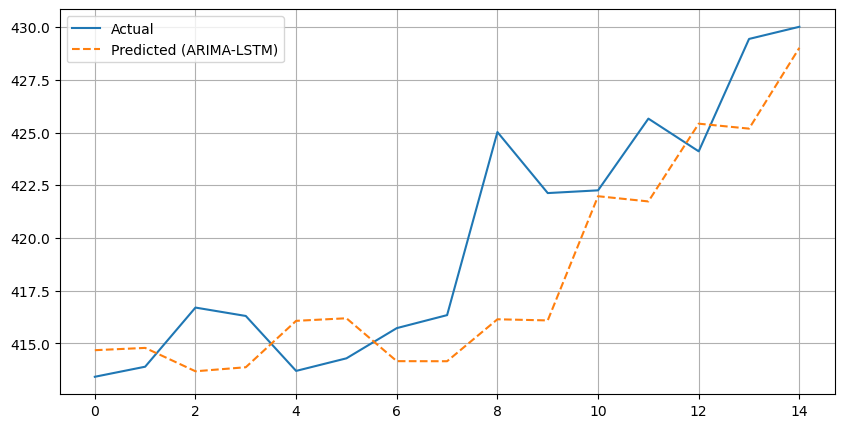

RMSE is 3.51559858819716


In [138]:
arima_lstm_predictions=np.array(predictions_arima[:n_pred])+np.array(lstm_predictions)
plt.figure(figsize=(10, 5))
plt.plot(X_test[:n_pred],label="Actual")
plt.plot(arima_lstm_predictions,label='Predicted (ARIMA-LSTM)', linestyle='--')
plt.grid(True)


plt.legend()
plt.show()


rmse = np.sqrt(mean_squared_error(X_test[:n_pred],arima_lstm_predictions))
print(f"RMSE is {rmse}")


In [121]:
np.array(predictions_arima[:n_pred])+np.array(lstm_predictions)

array([414.92594535, 414.917776  , 413.9382883 , 413.860083  ,
       416.2032811 , 416.40078847, 414.40596543, 414.52315544,
       416.3069688 , 416.43687332, 422.09671945, 421.9839939 ,
       425.61441092, 425.43995826, 429.23883025])

,MSFT
Date,
2024-10-10,413.419861
2024-10-11,413.897034
2024-10-14,416.700653
2024-10-15,416.302948
2024-10-16,413.698181
2024-10-17,414.294708
2024-10-18,415.726349
2024-10-21,416.342743
2024-10-22,425.021942


RMSE is 3.5012375846864385


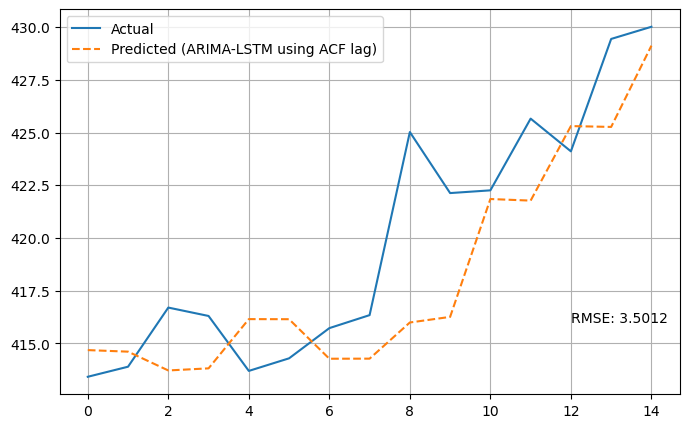

In [148]:
arima_lstm_predictions=np.array(predictions_arima[:n_pred])+np.array(lstm_predictions)

rmse = np.sqrt(mean_squared_error(X_test[:n_pred],arima_lstm_predictions))
print(f"RMSE is {rmse}")

plt.figure(figsize=(8, 5))
plt.plot(X_test[:n_pred],label="Actual")
plt.plot(arima_lstm_predictions,label='Predicted (ARIMA-LSTM using ACF lag)', linestyle='--')
plt.grid(True)


plt.legend()
plt.text(s=f"RMSE: {rmse:.4f}",x=12,y=416)
plt.savefig("result_arima_lstm_random_forest.png", dpi=300, bbox_inches='tight')
plt.show()



